# Demo: making initial conditions and visualising them

Take a dataset and create initial conditions for your specified grid, filling gaps with connected nearest neighbour (for filling in ice shelf cavities for example). 

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import warnings
import sys
sys.path.append('/home/users/birgal/')
from nemo_python.ics_obcs import create_ics

#### Load bathymetry files

In [2]:
# NEMO mesh mask and domain files
bathy_folder = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/'
nemo_mask    = xr.open_dataset(f'{bathy_folder}mesh_mask-20240201.nc').isel(time_counter=0)

## Create initial conditions
Note that this may require more memory than your notebook environment allows, so I normally call the functions in a python script instead.

In [3]:
variable='SALT'

source_folder = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/climatology/'
IC_folder     = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/'

In [3]:
in_file_source = f'{source_folder}{variable}_climatology_m01.nc';
output_file    = f'{IC_folder}SOSE-{variable}-initial-conditions-20240202.nc'
create_ics(variable, in_file_SOSE, output_file,
           source       = 'SOSE',
           source_coord = f'{source_folder}{variable}_climatology_m01.nc',
           nemo_coord   = f'{bathy_folder}domain_cfg-20240201.nc',
           nemo_mask    = f'{bathy_folder}mesh_mask-20240201.nc',
           salt_file    = f'{source_folder}SALT_climatology_m01.nc',
           num_iter     = 500,
           fill_value   = 0)

## Visualise initial conditions

In [4]:
# load initial conditions:
IC_ds  = xr.open_dataset(f'{IC_folder}SOSE-SALT-initial-conditions-20240202.nc').isel(time_counter=0)
src_ds = xr.open_dataset(f'{source_folder}SALT_climatology_m01.nc')

In [5]:
# x-coordinate of slice to look at and mark in the plots
coord = 440

Bird's eye view:

Text(0.5, 1.0, 'Source dataset values')

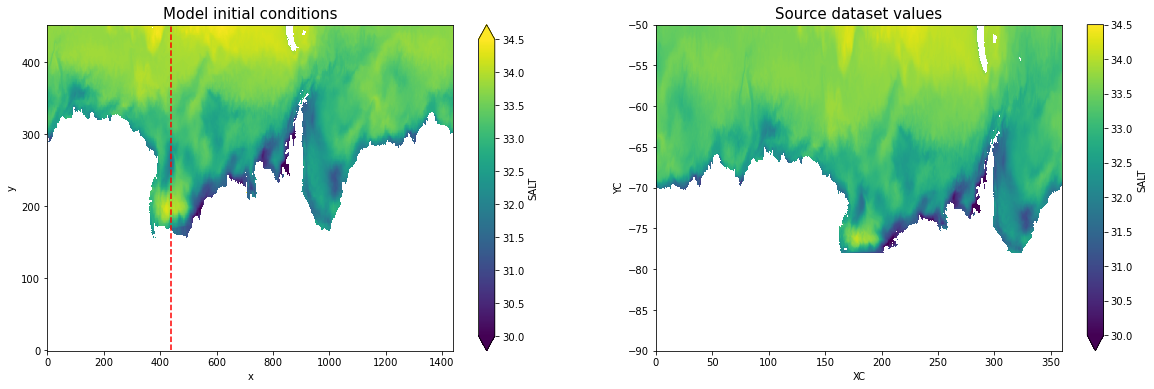

In [7]:
fig, ax = plt.subplots(1,2, figsize=(20, 6))

IC_ds_plot = xr.where(IC_ds.SALT==9999, np.nan, IC_ds.SALT) # mask filled land values
IC_ds_plot.isel(deptht=0).plot(ax=ax[0], vmin=30, vmax=34.5)
ax[0].plot([coord, coord], [0, 453], '--r')
ax[0].set_title('Model initial conditions', fontsize=15)

src_ds_plot = xr.where(src_ds.SALT==0, np.nan, src_ds.SALT) # mask filled land values
src_ds_plot.isel(Z=0).sel(YC=slice(-90,-49)).plot(ax=ax[1], vmin=30, vmax=34.5, ylim=(-90, -50))
ax[1].set_title('Source dataset values', fontsize=15)

And, ice shelf cavity transect view (to highlight the cavity fill methods):

In [8]:
# Load vertically and horizontally interpolated initial conditions where the cavities have not yet been filled
IC_start = xr.open_dataset(f'{IC_folder}temp/SOSE-SALT-IC-vertical-interp.nc').isel(x=coord)
# Points that are ocean and not filled in the initial conditions
cond = ((nemo_mask.tmask.isel(x=coord)==1) * (np.isnan(IC_start.SALT.values)))
IC_before_fill = xr.where(cond, 1000, IC_start.SALT.values)not_filled     = xr.where(cond, 1, 0) # identify points not filled
masked_missing = xr.where(cond, 1, np.nan)

# Land mask and depth values for plotting:
masked_land = xr.where((nemo_mask.tmask.isel(x=coord)==0), 1, np.nan)
nemo_depths = nemo_mask.gdept_0.isel(x=coord)

In the left plot below, the values missing from the original dataset or masked as land in that dataset are marked in dark blue. The bottom right plot shows the output from filling the misisng points sequentially with connected nearest neighbours.

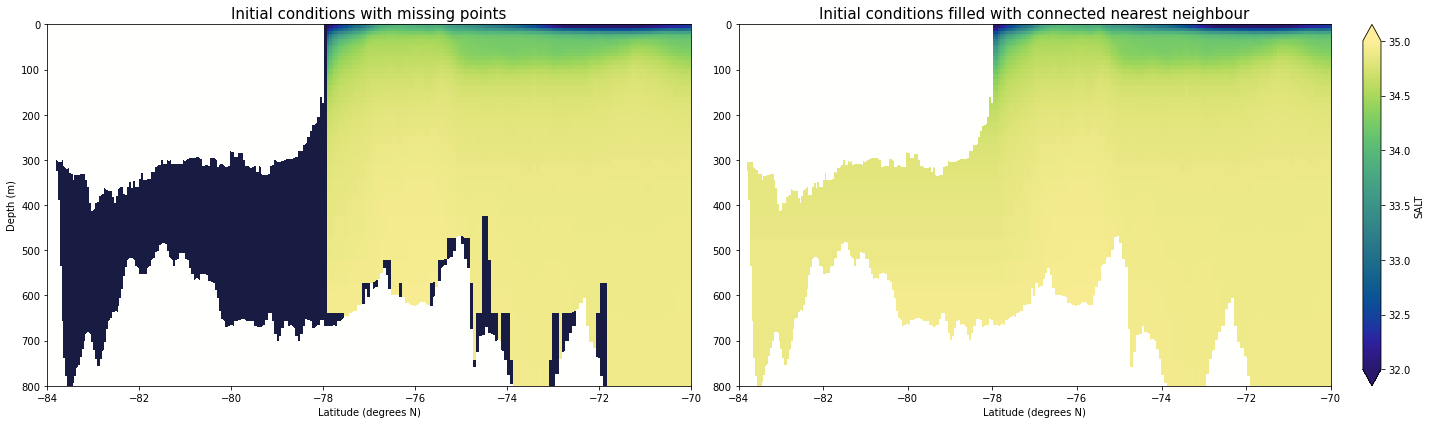

In [10]:
with warnings.catch_warnings():
    # pcolormesh complains because the depths grid is not strictly monotonically increasing, ignore for the purposes of this example
    warnings.filterwarnings("ignore",
                            "The input coordinates to pcolormesh are interpreted as cell centers, but "
                            "are not monotonically increasing or decreasing. This may lead to "
                            "incorrectly calculated cell edges, in which case, please supply explicit "
                            "cell edges to pcolormesh.",
                            UserWarning)
    
    kwags = {'cmap':cmocean.cm.haline, 'vmin':32, 'vmax':35}

    fig, ax = plt.subplots(1,2, figsize=(20,6))
    ax[0].set_title('Initial conditions with missing points', fontsize=15)
    ax[0].pcolormesh(nemo_mask.nav_lat.isel(x=coord), nemo_depths, IC_before_fill, **kwags)
    ax[0].pcolormesh(nemo_mask.nav_lat.isel(x=coord), nemo_depths, masked_land, cmap=cmocean.cm.gray_r)
    ax[0].pcolormesh(nemo_mask.nav_lat.isel(x=coord), nemo_depths, masked_missing, cmap=cmocean.cm.balance)
    ax[0].set_ylim(800,0); ax[0].set_xlim(-84,-70)
    
    ax[1].set_title('Initial conditions filled with connected nearest neighbour', fontsize=15)
    cm1 = ax[1].pcolormesh(nemo_mask.nav_lat.isel(x=coord), nemo_depths, IC_ds.SALT.isel(x=coord).values, **kwags)
    ax[1].pcolormesh(nemo_mask.nav_lat.isel(x=coord), nemo_depths, masked_land, cmap=cmocean.cm.gray_r)
    ax[1].set_ylim(800,0); ax[1].set_xlim(-84,-70)
    
    CB1 = fig.colorbar(cm1, ax=ax[1], fraction=0.03, extend='both', label='SALT')

    ax[0].set_ylabel('Depth (m)')
    ax[0].set_xlabel('Latitude (degrees N)')
    ax[1].set_xlabel('Latitude (degrees N)')
    
    fig.tight_layout()